In [1]:
import csv
import re
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Loading the data

In [2]:
torch.cuda.is_available()
device = torch.device("cuda")

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/eth_CS4NLP/project/qadata'

Mounted at /content/drive
test.txt  vardial_dev.txt  vardial_train_1.csv	vardial_train_2.csv


In [29]:
train_old = '/content/drive/MyDrive/eth_CS4NLP/project/qadata/vardial_train_1.csv'
train_path = '/content/drive/MyDrive/eth_CS4NLP/project/qadata/vardial_train_2.csv'
dev_path = '/content/drive/MyDrive/eth_CS4NLP/project/qadata/vardial_dev.txt'
test_path = '/content/drive/MyDrive/eth_CS4NLP/project/qadata/vardial_test.txt'

In [11]:
#todo: rewrite function, rename list of label
#IMPORT devset
dial_label = {
    0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'
}

fold_label = {
    'EML' : 0,
    'NAP' : 1,
    'PMS' : 2,
    'FUR' : 3,
    'LLD' : 4,
    'LIJ' : 5,
    'LMO' : 6,
    'ROA_TARA' : 7,
    'SCN' : 8,
    'VEC' : 9,
    'SC' : 10
}

def explain_label(label : int) -> str:
    """ 
    Given an integer label, convert it to the corresponding string label
    :param int label: integer label to be converted
    :return: string corresponding to the given label
    """
    return dial_label[label]

def encode_label(label : str) -> int:
    """ 
    Given a string label, encode it to the corresponding index
    :param string label: string label to be converted
    :return: int corresponding to the given label
    """
    return fold_label[label]

## Train_set

In [33]:
df_train = pd.read_csv(train_path)
#label sizes
label_sizes = df_train.groupby('label').size()
# Extract labels
final_lang = df_train['label'].unique()
#label list
train_labels =df_train['label']
label_sizes

label
0      7050
1     22096
2     58602
3     13578
4     23838
5     19137
6     85094
7     12591
8     58915
9     54078
10    33802
dtype: int64

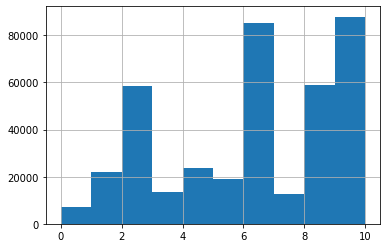

In [15]:
df_train['label'].hist() 

#### Remove duplications

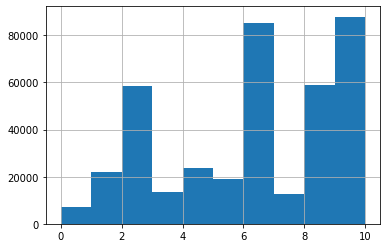

In [17]:
df_train_=df_train[['text','label']]
df_train_.drop_duplicates(subset ='text',keep = False, inplace = True, ignore_index=True) 
df_train_['label'].hist() 

## Train_old

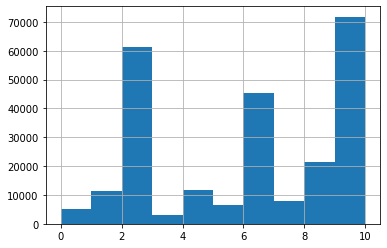

In [18]:
df_train = pd.read_csv(train_old)
label_sizes = df_train.groupby('label').size()
final_lang = df_train['label'].unique()
train_labels =df_train['label']
df_train['label'].hist()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


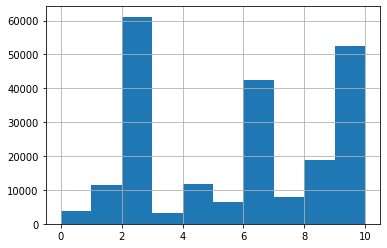

In [19]:
df_train_=df_train[['text','label']]
df_train_.drop_duplicates(subset ='text',keep = False, inplace = True, ignore_index=True) 
df_train_['label'].hist()

## Dev + Train

#### Dev set

(6801, 2)


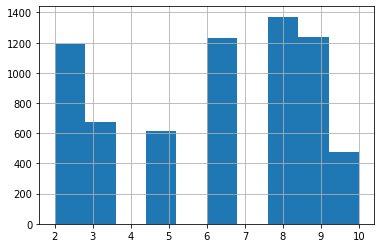

In [34]:
df_dev = pd.read_csv(dev_path, sep = "\t", names=["label", "text"])
df_dev['label'] = df_dev['label'].apply(encode_label)
df_dev = df_dev.fillna('')

label_sizes = df_dev.groupby('label').size()
final_lang = df_dev['label'].unique()
train_labels =df_dev['label']
print(df_dev.shape)
df_dev['label'].hist()

(6568, 2)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


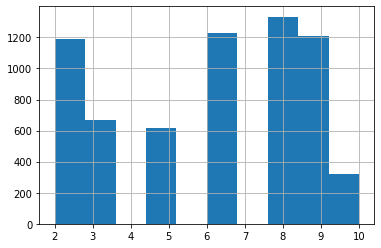

In [35]:
#remove duplicate
df_dev=df_dev[['text','label']]
df_dev.drop_duplicates(subset ='text',keep = False, inplace = True, ignore_index=True) 
print(df_dev.shape)
df_dev['label'].hist()

The result shows that there are still duplicate sentences in the dev_set

#### Concatenate train +  dev

In [54]:
df_traindev = df_train.append(df_dev, ignore_index=True)
train, dev = train_test_split(df_traindev, test_size=0.2, random_state = 113 ,shuffle= True)

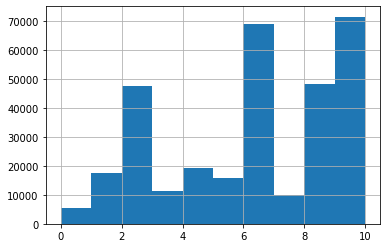

In [51]:
train['label'].hist()

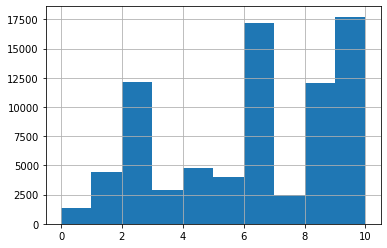

In [41]:
dev['label'].hist()

In [55]:
print(df_dev.shape)
print(df_dev['label'].unique()) #list of labels
print(dev.shape)
print(dev['label'].unique())
print(df_train.shape)
print(df_train['label'].unique())
print(train.shape)
print(train['label'].unique())

(6568, 2)
[ 6  8  9  5  3 10  2]
(79070, 2)
[ 5  9  6  2  3  1  8 10  4  0  7]
(388781, 2)
[ 0  1  2  3  4  5  6  7  8  9 10]
(316279, 2)
[ 9  3  6  2  1 10  4  8  5  7  0]


## Test set

In [36]:
df_test = pd.read_csv(test_path, sep = "\t", names=["text"])
df_test.shape

(11087, 1)

In [56]:
df_test.drop_duplicates(subset ='text',keep = False, inplace = True, ignore_index=True) 
df_test.shape

(10737, 1)

`There are also duplicated sentences in the test set`